In [2]:
import csv
import ccxt
import json
import time
import random
import numpy as np
import pandas as pd
from datetime import datetime
from songline import Sendline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

# Fetch Data

In [3]:
apiKey = '0CEGxdBVbnEcdyxjAJAxgAQByFBWXw6ZqXAVem1p'
apiSecret = 'qmgFDUVEKK7VAFO90pVKlNKhDf_0kMC2W0nv2FN4'

exchange = ccxt.ftx({'apiKey' : apiKey, 'secret' : apiSecret, 'enableRateLimit' : True})
exchange.headers = {'FTX-SUBACCOUNT': 'TestSub',}

In [4]:
''''15s': '15',
    '1m': '60',
    '5m': '300',
    '15m': '900',
    '1h': '3600',
    '4h': '14400',
    '1d': '86400','''

def OHLCV(symbol, tf, limit=None):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=tf, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    return df

In [5]:
df = OHLCV('XRP/USD', '15m', limit=None)

In [6]:
df

,datetime,open,high,low,close,volume
0,2021-05-21 22:30:00,0.988500,1.012700,0.985725,0.986225,712447.058950
1,2021-05-21 22:45:00,0.986225,0.995500,0.977325,0.983675,487775.729325
2,2021-05-21 23:00:00,0.983675,1.010925,0.972200,1.008350,543607.898225
3,2021-05-21 23:15:00,1.008350,1.017150,0.992700,0.998100,673434.307375
4,2021-05-21 23:30:00,0.998100,1.005475,0.987500,0.992800,313095.088850
...,...,...,...,...,...,...
1496,2021-06-06 12:30:00,0.937125,0.937125,0.932500,0.934500,70166.634175
1497,2021-06-06 12:45:00,0.934500,0.935600,0.931100,0.932800,102516.864875
1498,2021-06-06 13:00:00,0.932800,0.936950,0.932650,0.932750,130662.238300
1499,2021-06-06 13:15:00,0.932750,0.933800,0.928900,0.931875,113101.412950


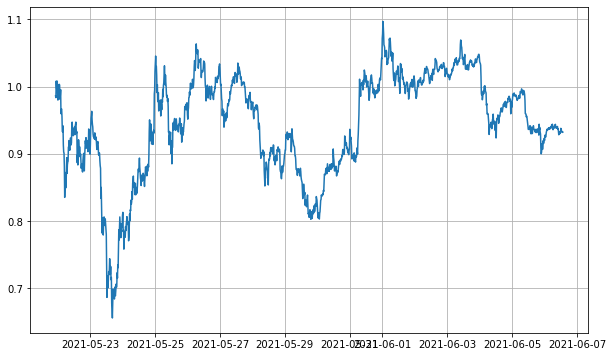

In [7]:
plt.figure(figsize=(10,6))
plt.plot(df['datetime'], df['close'])
plt.grid()

# Env Rebalance

In [8]:
class EnvRebalance(): 
    def __init__(self, 
                 data=None, # 5m XRP/USDT
                 initial_capital=100, 
                 fee=0.02, #0.020% per cost
                 time_base = 1, # tb1 = 5m, tb2 = 10m
                 min_diff = 0.02, # 0.01=1%, 0.02=2% ... per asset value
                 fixed_asset_value = 50):
        #Data
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        
        #Rebalance parameter
        self.tb = time_base
        self.min_diff = min_diff
        self.fixed = fixed_asset_value
        
        #Cap & fee
        self.initial_capital = initial_capital
        self.fee = fee
        
        #For plot visualize
        self.n_buy = None
        self.n_sell = None
        self.marker = None

        self.cur_step = None
        self.position = None
        self.stock_price = None
        self.cash = None
        
        self.action_space = np.arange(3) #Action space <------ [0,1,2]
        self.state_space = 3 #State space <------ [pos, price, cash]
        
        self.reset()
         
    def reset(self):
        self.marker = []
        self.action_plot = []
        self.n_buy = 0
        self.n_sell = 0
        self.cur_step = 0
        self.position = 0
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash = self.initial_capital
        return self._get_obs()
        
    def step(self):
        prev_val = self.port_val()
        
        self.cur_step += self.tb
        self.stock_price = self.stock_price_history[self.cur_step]
        self.rebalance()
        
        cur_val = self.port_val()
        reward = cur_val - prev_val
        done = self.cur_step == self.n_step - self.tb
        info = {'cur_val': cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self): 
        obs = np.empty(self.state_space)
        obs[0] = self.position
        obs[1] = self.stock_price
        obs[2] = self.cash
        return obs
      
    def port_val(self):
        return self.position*self.stock_price + self.cash 
    
    def rebalance(self): 
        fixed = self.fixed
        asset = self.position
        price = self.stock_price
        
        asset_val = price*asset
        
        diff = asset_val - fixed
        mdf = self.min_diff*fixed # %diff asset value
        
        #Sell 0
        if diff>mdf:
            unit = diff/price
            self.cash += (unit*price)-(unit*price*self.fee)
            self.position -= unit
            self.n_sell += 1
            self.marker.append(0)
        #Buy
        elif diff<-mdf:
            unit = abs(diff)/price
            self.cash -= (unit*price)+(unit*price*self.fee)
            self.position += unit
            self.n_buy += 1
            self.marker.append(2)
        #Wait
        else:
            self.marker.append(1) 
  

In [9]:
tb = 15
data = df['close']
rb = EnvRebalance(data, initial_capital=100, min_diff=0.02, fixed_asset_value=50) 

# Backtest

In [10]:
state = rb.reset()
    
equity_curve = np.empty([rb.n_step-1])
total_reward = np.zeros(1)
i = 0
    
while True:

    equity_curve[i] =  rb.port_val()
    #print(f'{i} Price:{rb.stock_price}, Cash:{rb.cash:.3f}, Asset:{rb.position:.3f}, Value:{rb.position*rb.stock_price:.3f}')

    next_state, reward, done, info = rb.step()
    
    total_reward += reward
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {rb.initial_capital:.2f}')
        print(f'end_portfolio_value: {rb.port_val():.2f}')
        print(f'total_profit: {total_reward[0]:.2f}')
        print(f'%profit: {total_reward[0]/rb.initial_capital*100:.2f} %')
        print(f'buy: {rb.n_buy}, sell: {rb.n_sell}')
        print(f'Len:{rb.n_step}, {rb.n_step*tb/60:.2f} hrs. = {(rb.n_step*tb/60)/24:.2f} days')
        print("=======================================")

        break

                  
            

========Backtesting Performance========
begin_portfolio_value: 100.00
end_portfolio_value: 95.23
total_profit: -4.77
%profit: -4.77 %
buy: 91, sell: 94
Len:1501, 375.25 hrs. = 15.64 days


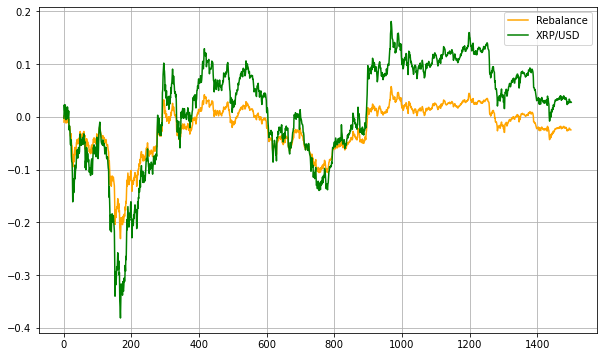

In [11]:
plt.figure(figsize=(10,6))
plt.plot(pd.DataFrame(equity_curve).pct_change().cumsum(), 'orange')
plt.plot(df['close'].pct_change().cumsum(), 'green')
plt.legend(['Rebalance', 'XRP/USD'])
plt.grid()